# Implementation of different versions of the benefit difference fairness function

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_results_over_lambdas
from src.training import train_multiple

## The parameters used by the the original authors  

In [7]:
dim_x = 1
training_parameters = {
    'keep_collected_data': False,
    'use_sensitve_attributes': False,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    #'fairness_rate':1000,
    'fraction_protected':0.5,
    'num_test_samples': 2000,
    'bias': True,
    'benefit_value_function': demographic_parity
}
def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

dim_theta = dim_x + 1 if training_parameters['bias'] else dim_x
#training_parameters['theta'] = [-3.5, 0.6]
training_parameters['feature_map'] = IdentityFeatureMap(dim_theta)
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']
training_parameters['utility_value_function'] = util_func


## Correct Benefit Difference

kretschmar/Documents/master-thesis/src/policy.py:301: RuntimeWarning: overflow encountered in exp
  denominator = np.expand_dims(1.0 + np.exp(np.matmul(phi, self.theta)), axis=1)
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/fkretschmar/Documents/master-thesis/src/policy.py:301: RuntimeWarning: overflow encountered in exp
  denominator = np.expand_dims(1.0 + np.exp(np.matmul(phi, self.theta)), axis=1)
/home/fkretschmar/Documents/master-thesis/src/policy.py:301: RuntimeWarning: overflow encountered in exp
  denominator = np.expand_dims(1.0 + np.exp(np.matmul(phi, self.theta)), axis=1)
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

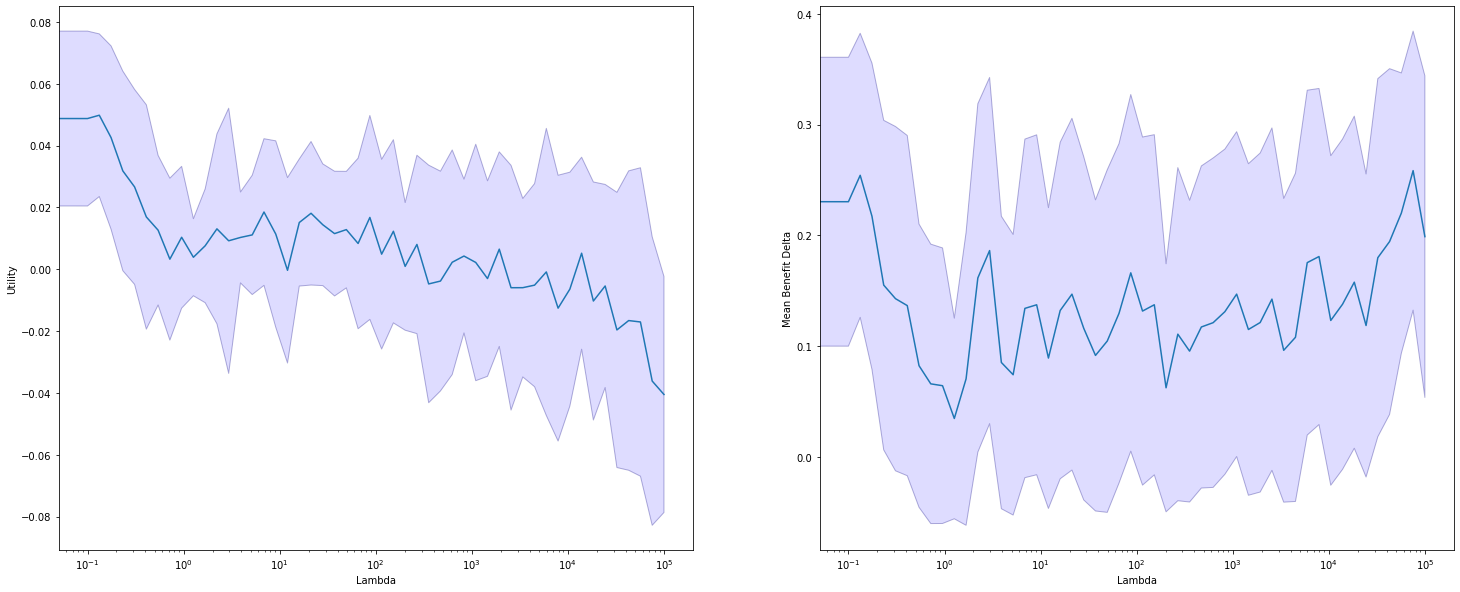

In [6]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)
    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)

    benefit_grad = benefit * phi/denominator

    if ips_weights is not None:
        benefit *= ips_weights
        benefit_grad *= ips_weights
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters['fairness_function'] = fairness_function
lambdas = np.logspace(-1, 5, base=10, endpoint=True, num=50)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

results = train_multiple(training_parameters, iterations=20, lambdas=lambdas, verbose=True)
plot_results_over_lambdas(
    results["utility_stats"]["mean"], 
    results["utility_stats"]["stddev"], 
    results["benefit_delta_stats"]["mean"], 
    results["benefit_delta_stats"]["stddev"], 
    lambdas, 
    file_path="results.png")